# 蓝色边缘程序使用pandas的改写

_由于有一些星表中包含缺省项，我们需要使用pandas中使用dataframe读取csv中自动将缺省项补上的优势，来优化我们的自动化程式_

_(fits的文件我们可以使用topcat改变格式并且给星表瘦身，以加快程序读取速度）_

我们需要实现的功能包含以下几点：

输入：
* csv星表**_的名字_**
* 需要画的色指数的两个测光点（比如 $ J - H $ 我们需要输入$J$ 和 $H$）

程序中自带（我们所需要限定的条件）
_写在其中的某一个cell中作为 filt 条件_
* 限定的误差范围（测光数据一般选择 0.3，光谱数据可以具体再定，基本上认为不太离谱的都可以用）
* 去掉错误的点（见之前的程序)

输出：
* 颜色-teff 图

Now,trying:
* SFD: 一个新的ratio,比如说0.05，把这个ratio底下的部分输入进SFD,判断：E(B-V) <0.3 的值就是我们零消光的值。这个值去拟合一个新的curve。

In [23]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import datetime
%matplotlib inline

data_dir = '/Users/SY/Desktop/obic/data/'
#data_dir = '/Users/dengdingshan/Documents/data/obic/'

In [24]:
#read as pandas
starcatalog_fram = pd.read_csv(data_dir + 'lamost_2mass_new2.csv')

###########

#starcatlog_fram = starcatlog_fram.ix[:,:517]
#print(starcatalog_fram)

In [25]:
#read parsec
parsec_fram = pd.read_csv(data_dir + 'parsec_jhkw.csv')

############

#print(parsec_fram.values)

In [26]:
### Elective CHOICE

########### I.
#change logTeff into Teff.

# def tenn(x):
#     y=10 ** x
#     return y

# Teff_tbl = starcatalog['logTeff'].apply(tenn)
###########

########### II.
#add [Teff] into DATAFRAME

#data_fram = starcatalog_fram[['TEFF_1','ERR_TEFF_1','Jmag_1','e_Jmag_1','Hmag_1','e_Hmag_1']]
#print(data_fram)
###########

########### III.
# fill the NaN blocks with 0

starcatalog_fram_fil = starcatalog_fram.fillna(0)

#print(starcatalog_fram_fil['LOGG'])
############


In [27]:
starcatalog_fram_fil.columns

Index(['col1', 'TEFF', 'ERR_TEFF', 'RA', 'DEC', 'LOGG', 'ERR_LOGG', '2MASS',
       'RAJ2000', 'DEJ2000', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'Jmag',
       'Hmag', 'Kmag', 'e_Jmag', 'e_Hmag', 'e_Kmag', 'Qfl', 'Rfl', 'X',
       'MeasureJD', 'angDist'],
      dtype='object')

In [28]:
### variables

teff = 'TEFF'

color1 = 'Jmag'
color2 = 'Hmag'
err_teff = 'ERR_TEFF'

err_c1 = 'e_' + color1
#'e_' + color1
#color1 + 'err' 
#color1 + 'err'
#ERR_' + color1
#'e_' + color1

err_c2 = 'e_' + color2
#'ERR_' + color2
#'e_' + color2

In [45]:
### we just need the mainsquence (dwarf stars)

# #judge logg >3.7

starcatalog_fram_fil = starcatalog_fram_fil[(starcatalog_fram_fil['LOGG']>3.5)]
parsec_fram = parsec_fram[(parsec_fram['logg']>3.5)]                                            

In [46]:
### get the good stars

# judge  data
starcatalog_fram_fil=starcatalog_fram_fil[((starcatalog_fram_fil[err_c1] != 0) \
                                          & (starcatalog_fram_fil[err_c2] != 0)\
                                          & (starcatalog_fram_fil[err_c1] != -99) \
                                          & (starcatalog_fram_fil[err_c2] != -99))\
                                         & ((starcatalog_fram_fil[color1] != 0)\
                                           & (starcatalog_fram_fil[color2] != 0)\
                                           & (starcatalog_fram_fil[color1] != -99) \
                                           & (starcatalog_fram_fil[color2] != -99))\
                                         &((starcatalog_fram_fil[err_c1] <=0.03)\
                                          & (starcatalog_fram_fil[err_c2] <=0.03))]
### additional judgement

# starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil[err_c1] <=0.2)\
#                                            &(starcatalog_fram_fil[err_c2] <=0.05)]

print(starcatalog_fram_fil.iloc[:,0].size)

28114


In [47]:
### draw the png of errTeff 

# plt.figure(3)
# plt.xlabel('$T_\mathrm{eff}(K)$',fontsize=14)
# plt.ylabel('$σ_\mathrm{Teff}$',fontsize=14)
# plt.scatter(starcatalog_fram_fil[teff],starcatalog_fram_fil[err_teff],\
#             c='steelblue',s=8, edgecolors='None',alpha=0.2,label='$σ_\mathrm{Teff}$(LAMOST)')
# plt.legend(loc='lower right')
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.savefig(savename3,dpi=200)  
# plt.show()

### 

In [48]:
# cut source g-r:0.440
origin = starcatalog_fram_fil
# starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil[color1]-starcatalog_fram_fil[color2]>= -0.440)\
#                                          & (starcatalog_fram_fil[color1]>=12)]

In [49]:
#filt the good one
#apogee_tbl_fil = apogee_tbl[np.argwhere(np.logical_and(apogee_tbl['teff'] > 0, apogee_tbl['logg'] > -3))]
#apogee_tbl_fil = apogee_tbl_fil[np.argwhere(np.logical_and(apogee_tbl_fil['j'].flatten() > -1, \
#                                                           apogee_tbl_fil['h'].flatten() > -1))]
#USE goodOB 


starcatalog_fram_fil=starcatalog_fram_fil[(((starcatalog_fram_fil[err_teff] != 0 )\
                                          & (starcatalog_fram_fil[teff]>= 10000))\
                                          #& (starcatalog_fram_fil[teff]<= 16000))
                                          & (((starcatalog_fram_fil[err_teff]< 630)\
                                          &(starcatalog_fram_fil[teff]> 9000))\
                                          |((starcatalog_fram_fil[err_teff]< 500)\
                                          & (starcatalog_fram_fil[teff]<= 9000))))]
print(np.max(starcatalog_fram_fil[teff]))

25258.838


In [50]:
# Determine the input numbers.

# Bin width, usually 50 (for more scatter, try 1000 or other figures)
#bin_width = 1000

# Ratio of the bluest edge, usually 5%
rat = 5

# Low end criteria. If the number in a bin is lower than this number then neglect.  
low_crit = 50

In [51]:
# input the data of Bessell. M.S. & Brett. J.M. 1988
# BBFrame is the dataframe of the ic data 

BBFrame=pd.DataFrame({'J-H':[-0.09,-0.08,-0.07,-0.06,-0.05,-0.03,-0.03,-0.01,0.0,0.02,0.06],\
                      'Teff':[22300,19000,17200,15400,14100,13000,11800,10700,9480,8810,8160]})


In [52]:
# parsec point
parsecframe = parsec_fram[((parsec_fram['Age'] == 3980000)\
                           &(parsec_fram['logTe'] <= 4.361)\
                           &(parsec_fram['logTe'] >= 4.000))]
parsec_teff =10**parsecframe['logTe'] 
parsec_color = parsecframe[color1] - parsecframe[color2]
#print(parsecframe.values)
                                         

In [53]:
# Find the start point and bin number of Teff. 
# Start point: the first number divisible by bin_width smaller than min(teff)
# Bin number: Start from start point and cover all the teff range.


#teff_start = min(apogee_tbl_fil['teff']) - min(apogee_tbl_fil['teff']) % (bin_width/2)
#bin_number = math.ceil((max(apogee_tbl_fil['teff']) - teff_start) / bin_width)

#teff_start = min(starcatalog_fram_fil[teff])-min(starcatalog_fram_fil[teff])%(bin_width / 2)

teff_start= 10000

#bin_number = math.ceil((max(starcatalog_fram_fil[teff])-teff_start) / bin_width)


In [54]:
#filt BBFrame
BBFrame_fil=BBFrame[BBFrame['Teff'] >= teff_start]

In [55]:
def data(teff_start,ratio,low_crit,ratio_SFD):
    
    start_time = time.time()
    int_teff = []
    int_color = []
    bin_int_color = []
    
    SFD_RA = []; SFD_DEC = []; SFD_TEFF = []; SFD_color1 = []; SFD_color2 = [];
    
    data_final = pd.DataFrame(columns=[teff,color1,color2])
    teff_judge = teff_start
    while teff_judge < np.max(starcatalog_fram_fil[teff]) - 1000:
       
        if teff_judge <9000:
            bin_width = 100
        else:
            bin_width = 630

        bin_tbl =starcatalog_fram_fil[np.logical_and(starcatalog_fram_fil[teff] > teff_judge, \
                                                starcatalog_fram_fil[teff] < teff_judge+bin_width)]

        #print(teff_judge)
       
        
        if len(bin_tbl) < low_crit:
            teff_judge = teff_judge+bin_width
            continue
            
        source_num = 0
        #print(len(bin_tbl))

        while source_num != len(bin_tbl):
            source_num = len(bin_tbl)

        data_final = data_final.append(bin_tbl[[teff,color1,color2]])
        #print(len(bin_tbl))

        int_teff.append(float(teff_judge+bin_width/2))
        bin_tbl['color'] = bin_tbl[color1]-bin_tbl[color2]
        bin_sort = bin_tbl.sort_index(axis = 0,ascending = True,by = 'color')
        
        # 每个bin中前ratio_SFD的部分用于取得ebv
        color_SFD = bin_sort['color'].values[:math.ceil(len(bin_tbl)*ratio_SFD/100)]
        bin_tbl_SFD = bin_sort[(bin_sort['color']<=np.max(color_SFD))]
        
        for ppp in range(len(bin_tbl_SFD)):
            SFD_RA.append(bin_tbl_SFD['RA'].values[ppp])
            SFD_DEC.append(bin_tbl_SFD['DEC'].values[ppp])
            SFD_TEFF.append(bin_tbl_SFD['TEFF'].values[ppp])
            SFD_color1.append(bin_tbl_SFD[color1].values[ppp])
            SFD_color2.append(bin_tbl_SFD[color2].values[ppp])
        
        # 每个bin中前ratio(usually 5%)的部分 用于取得内禀色指数int_color
        color5 = bin_sort['color'].values[:math.ceil(len(bin_tbl)*ratio/100)]
        bin_tbl_5 = bin_sort[(bin_sort['color']<=np.max(color5))]
        
        if len(color5) != 0:
            bin_mean = np.median(color5)
            bin_sigma = np.std(color5)
            bin_int_color = color5\
            [((color5<= bin_mean+3*bin_sigma)\
            & (color5>= bin_mean-3*bin_sigma))]

            int_color.append(np.median(bin_int_color))
            
        teff_judge = teff_judge+bin_width
        
    SFD_tbl_final = pd.DataFrame({'TEFF':np.array(SFD_TEFF),'RA':np.array(SFD_RA),\
                                  'DEC':np.array(SFD_DEC),color1:np.array(SFD_color1),\
                                 color2:np.array(SFD_color2)})
    
    print(time.time() - start_time)
    print(int_teff,int_color)
#     print(bin_mean)
#     print(data_final.iloc[:,0].size)
    return int_teff,int_color,data_final,SFD_tbl_final

In [56]:
# SFD ratio

ratio_SFD = 5

# fitting curve
int_teff,int_color,data_final,SFD_tbl_ratio = data(teff_start,rat,low_crit,ratio_SFD)

fc = np.polyfit(int_teff, int_color, 3)#用3次多项式拟合
fitcurve = np.poly1d(fc)
# print(fitcurve) #在屏幕上打印拟合多项式

colorvals=fitcurve(int_teff)

# print(len(colorvals),len(int_teff))
#print(len(bin_tbl_final[teff].values))

# SFD_tbl_ratio[teff]


/Users/SY/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/SY/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


1.3473942279815674
[10315.0, 10945.0, 11575.0, 12205.0, 12835.0, 13465.0, 14095.0, 14725.0, 15355.0, 15985.0, 17245.0, 17875.0, 18505.0, 19135.0, 19765.0, 20395.0, 21025.0, 21655.0, 22285.0, 22915.0] [-0.042999999999999261, -0.051000000000000156, -0.045999999999999375, -0.052999999999999048, -0.048500000000000654, -0.048000000000000043, -0.051000000000000156, -0.057000000000000384, -0.070000000000000284, -0.062999999999998835, -0.10700000000000021, 0.020999999999999908, -0.066999999999999282, -0.060000000000000497, -0.125, -0.1130000000000031, 0.022999999999999687, -0.047000000000000597, 0.025000000000000355, 0.020999999999999019]


In [57]:
## use SFD dustmap
from __future__ import print_function
from astropy.coordinates import SkyCoord
from astropy import units as u
from dustmaps.sfd import SFDQuery

sfd = SFDQuery()

## ebv前的系数需要去文献中拿到。目前使用的是r和i的
# Const1 = 0.709 #J #3.303 #g #2.285 #r 
# Const2 = 0.449 #H #2.285 #r #1.698 #i

time_start = time.time()
SFD_catalog_color = []
SFD_catalog_teff = []
lens = len(SFD_tbl_ratio)

ebv_final = []

# 判断ebv < 0.05，就拿入下一个数组，最后一起画在图上
print(lens)
for i in range(lens):
    coords = SkyCoord(SFD_tbl_ratio['RA'].values[i],SFD_tbl_ratio['DEC'].values[i],\
                      frame = 'icrs',unit = 'deg')
    ebv = sfd(coords)
    ebv_final.append(ebv)
    
#     A_c1 = Const1*ebv;
#     A_c2 = Const2*ebv;

    if ebv < 0.05:
        SFD_colorindex = SFD_tbl_ratio[color1].values[i]\
        - (SFD_tbl_ratio[color2].values[i])
        SFD_catalog_color.append(SFD_colorindex)
    
        SFD_catalog_teff.append(SFD_tbl_ratio[teff].values[i])
        print(i)
#     print(i)

print(time.time() - time_start)

1433
0
1
2
3
7
8
9
10
11
12
13
14
29
30
31
37
38
44
49
51
52
53
54
56
57
58
59
61
62
64
66
77
78
79
80
82
83
88
91
94
95
97
101
105
108
109
133
141
145
153
154
155
156
157
158
167
171
172
175
178
187
192
201
215
216
218
225
229
231
235
236
240
248
251
255
256
257
258
275
301
302
303
309
310
311
313
314
316
317
319
323
331
332
336
339
344
370
371
375
380
381
382
384
385
396
412
415
440
467
468
477
478
479
480
481
482
486
490
491
492
497
498
506
509
524
525
526
536
571
575
589
590
597
601
602
604
605
607
611
612
614
617
627
631
632
640
642
667
685
690
691
694
698
699
700
701
703
706
707
712
715
741
742
746
750
751
753
760
773
777
778
789
798
811
813
824
892
903
951
953
992
993
994
995
997
998
999
1005
1008
1009
1010
1014
1016
1024
1026
1030
1031
1034
1041
1047
1060
1089
1108
1109
1110
1114
1115
1119
1120
1128
1166
1169
1170
1171
1175
1178
1179
1180
1181
1183
1185
1197
1199
1204
1205
1207
1208
1238
1244
1248
1250
1258
1267
1268
1285
1286
1288
1293
1300
1301
1305
1332
1384
1387
1396
1397
1

In [58]:
### figures & Savename
cc1 = 'J'
cc2 = 'H'

#save = data_dir + 'pictures/'
save = '/Users/SY/Desktop/obic/picture/'

i = datetime.datetime.now()
date_now = "%s_%s_%s_" % (i.year, i.month, i.day) 
ylabel = '$%s - %s$'%(cc1,cc2) 
savename1 = save + date_now + cc1 + cc2 + 'logg3'+'.png'
savename2 = save + date_now + cc1 + '_HR_' + cc2 +'.png'
savename3 = save + date_now + 'errteff.png'

savename5 = save + date_now + cc1 + cc2 + '_logg30_SFD'+'5%'+'.png'


In [59]:
# plt hist of ebv

# plt.hist(ebv_final,1000)
# plt.savefig(save+'ebv.png',dpi = 200)
# plt.xlim(0,2)
# plt.show()

# 拟合SFD

fcc = np.polyfit(SFD_catalog_teff, SFD_catalog_color, 3)#用3次多项式拟合 SFD
fitcurve = np.poly1d(fcc)
print(fitcurve) #在屏幕上打印拟合多项式

SFD_vals = fitcurve(SFD_catalog_teff)



           3             2
5.655e-14 x - 2.188e-09 x + 2.077e-05 x - 0.1006


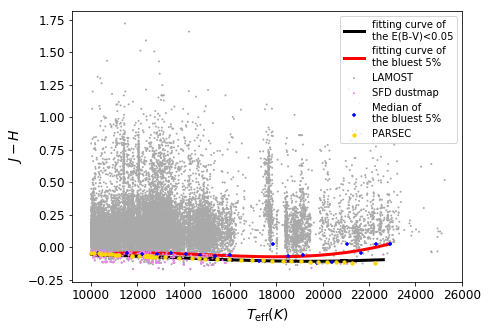

In [62]:
#PLT
plt.figure(1,figsize=(7, 5))  
plt.xlabel('$T_\mathrm{eff}(K)$',fontsize=14)
plt.ylabel(ylabel,fontsize=14)
#plt.ylim(-4,9)

# the data we use
plt.scatter(starcatalog_fram_fil[teff], starcatalog_fram_fil[color1]-starcatalog_fram_fil[color2],\
            c='darkgray',s=4, edgecolors='None',label='LAMOST')

# data we use in the SFD dustmap
plt.scatter(SFD_catalog_teff,SFD_catalog_color,alpha=1,edgecolors='None',c='violet',s=4,label='SFD dustmap',zorder=2)

# SFD fitcurve
plt.plot(SFD_catalog_teff, SFD_vals, c='black',linewidth = 3.,label='fitting curve of \nthe E(B-V)<0.05',zorder=1)

# ic plot from blue edge
plt.plot(int_teff, colorvals, c='r',linewidth = 3.,label='fitting curve of \nthe bluest 5%',zorder=1)

# ic from blue edge
plt.scatter(int_teff, int_color, edgecolors='None',c='b', marker = '+',s=11,label='Median of\nthe bluest 5%',zorder=2)

# ic from Allen's work 
# plt.scatter(BBFrame_fil['Teff'],BBFrame_fil['J-H'],c='lime',s=11,label='Allen',zorder=2)

# ic from parsec
plt.scatter(parsec_teff,parsec_color,c='gold',s=11,label='PARSEC',zorder=2)

### Draw the plot

# plt.xlabel('$T_\mathrm{eff}$'); plt.ylabel(ylabel)
#plt.scatter(BBFrame_fil['Teff'],BBFrame_fil['J-H'],c='#FF6666',s=11,label='Allen')

plt.legend(loc='upper right')
#new_ticks = np.linspace(-1,2,7)
#plt.yticks(new_ticks)
# plt.ylim(np.min(starcatalog_fram_fil[color1] - starcatalog_fram_fil[color2]) - 0.5,\
#         np.max(starcatalog_fram_fil[color1] - starcatalog_fram_fil[color2]))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig(savename1,dpi=200)
plt.savefig(savename5,dpi=200)
plt.show()

### some other features

5


TypeError: data() missing 1 required positional argument: 'ratio_SFD'

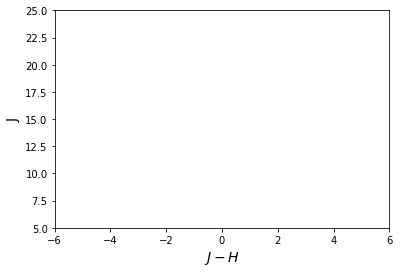

In [84]:
# H-R 1
plt.figure(2)
plt.xlabel(ylabel,fontsize=14); plt.ylabel(cc1,fontsize=14)
plt.xlim(-6,6)
plt.ylim(5,25)
# for rat in ratio:
print(rat)
int_teff,int_color,data_final = data(teff_start,rat,low_crit)

cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(origin[color1]-origin[color2], origin[color1],\
            c= 'darkgray',s=5,edgecolors = 'None',alpha = 1,cmap=cm,label='all sources')
plt.scatter(data_final[color1]-data_final[color2], data_final[color1],\
             c='g',s=5, edgecolors='None', alpha=1,label='selected sources')
#plt.colorbar(sc)
plt.legend(loc='upper right')
# new_ticks = np.linspace(-2,3,18)
# plt.xticks(new_ticks)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(savename2,dpi=200)    
plt.show()

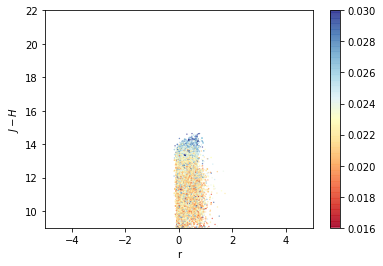

In [43]:
# 赫罗图 2
plt.xlabel('r')
plt.ylabel(ylabel)

cm = plt.cm.get_cmap('RdYlBu')

sc = plt.scatter(starcatalog_fram_fil[color1]-starcatalog_fram_fil[color2],starcatalog_fram_fil[color1],\
            c = starcatalog_fram_fil[err_c1],s=2,edgecolors = 'None',alpha = 0.7,cmap=cm)

plt.colorbar(sc)

plt.xlim(-5,5)
plt.ylim(9,22)
plt.savefig(save+'HR.png',dpi=200)
plt.show()

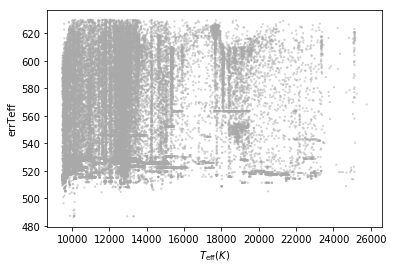

In [44]:
plt.figure(3)
plt.xlabel('$T_\mathrm{eff}(K)$')
plt.ylabel('errTeff')
plt.scatter(starcatalog_fram_fil[teff],starcatalog_fram_fil[err_teff],\
            c='darkgray',s=5, edgecolors='None', alpha=0.5)
plt.show()